# Tutorial - Time series forecasting

## Introduction

Time series are an ubiquitous type of data in all types of processes. Producing forecasts for them can be highly valuable in domains like retail or industrial manufacture, among many others.

Lightwood supports time series forecasting (both univariate and multivariate inputs), handling many of the pain points commonly associated with setting up a manual time series predictive pipeline. 

In this tutorial, we will train a lightwood predictor and analyze its forecasts for the task of counting sunspots in monthly intervals.

## Load data

Let's begin by loading the dataset and looking at it:

In [1]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/mindsdb/benchmarks/main/benchmarks/datasets/monthly_sunspots/data.csv")
df

,Month,Sunspots
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0
...,...,...
2815,1983-08,71.8
2816,1983-09,50.3
2817,1983-10,55.8
2818,1983-11,33.3


This is a very simple dataset. It's got a single column that specifies the month in which the measurement was done, and then in the 'Sunspots' column we have the actual quantity we are interested in forecasting. As such, we can characterize this as a univariate time series problem.

## Define the predictive task

We will use Lightwood high level methods to state what we want to predict. As this is a time series task (because we want to leverage the notion of time to predict), we need to specify a set of arguments that will activate Lightwood's time series pipeline:

In [2]:
from lightwood.api.high_level import ProblemDefinition

[nltk_data] Downloading package punkt to /home/runner/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
INFO:lightwood-2407:No torchvision detected, image helpers not supported.
INFO:lightwood-2407:No torchvision/pillow detected, image encoder not supported


In [3]:
tss = {'horizon': 6,   # the predictor will learn to forecast what the next semester counts will look like (6 data points at monthly intervals -> 6 months)
       'order_by': 'Month', # what column is used to order the entire datset
       'window': 12           # how many past values to consider for emitting predictions
      }

pdef = ProblemDefinition.from_dict({'target': 'Sunspots',         # specify the column to forecast
                                    'timeseries_settings': tss    # pass along all time series specific parameters
                                   })

Now, let's do a very simple train-test split, leaving 10% of the data to check the forecasts that our predictor will produce:

In [4]:
cutoff = int(len(df)*0.9)

train = df[:cutoff]
test = df[cutoff:]

print(train.shape, test.shape)

(2538, 2) (282, 2)


## Generate the predictor object

Now, we can generate code for a machine learning model by using our problem definition and the data:

In [5]:
from lightwood.api.high_level import (
    json_ai_from_problem,
    code_from_json_ai,
    predictor_from_code
)

json_ai = json_ai_from_problem(df, problem_definition=pdef)
code = code_from_json_ai(json_ai)
predictor = predictor_from_code(code)

# uncomment this to see the generated code:
# print(code)

INFO:type_infer-2407:Analyzing a sample of 2467
INFO:type_infer-2407:from a total population of 2820, this is equivalent to 87.5% of your data.
INFO:type_infer-2407:Infering type for: Month
INFO:type_infer-2407:Column Month has data type date
INFO:type_infer-2407:Infering type for: Sunspots
INFO:type_infer-2407:Column Sunspots has data type float
INFO:dataprep_ml-2407:Starting statistical analysis
/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/dataprep_ml/cleaners.py:152: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(element, infer_datetime_format=True).apply(lambda x: x.timestamp())
INFO:dataprep_ml-2407:Finished statistical analysis


## Train

Okay, everything is ready now for our predictor to learn based on the training data we will provide.

Internally, lightwood cleans and reshapes the data, featurizes measurements and timestamps, and comes up with a handful of different models that will be evaluated to keep the one that produces the best forecasts.

Let's train the predictor. This should take a couple of minutes, at most:

In [6]:
predictor.learn(train)

INFO:dataprep_ml-2407:[Learn phase 1/8] - Statistical analysis
INFO:dataprep_ml-2407:Starting statistical analysis
/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/dataprep_ml/cleaners.py:152: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(element, infer_datetime_format=True).apply(lambda x: x.timestamp())
INFO:dataprep_ml-2407:Finished statistical analysis
DEBUG:lightwood-2407: `analyze_data` runtime: 0.09 seconds
INFO:dataprep_ml-2407:[Learn phase 2/8] - Data preprocessing
INFO:dataprep_ml-2407:Cleaning the data
/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/dataprep_ml/cleaners.py:152: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of i

[16:21:04] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
[16:21:04] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
[16:21:04] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
[16:21:04] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
[16:21:04] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1
[16:21:04] WARNING: ../src/learner.cc:339: No visible GPU is found, setting `gpu_id` to -1


INFO:lightwood-2407:Loss of 6.255893111228943 with learning rate 0.05
INFO:lightwood-2407:Found learning rate of: 0.05
INFO:lightwood-2407:Loss @ epoch 1: 0.5818348526954651
INFO:lightwood-2407:Loss @ epoch 2: 0.4797109067440033
INFO:lightwood-2407:Loss @ epoch 3: 0.48386093974113464
INFO:lightwood-2407:Loss @ epoch 4: 0.49511992931365967
INFO:lightwood-2407:Loss @ epoch 5: 0.39475566148757935
INFO:lightwood-2407:Loss @ epoch 6: 0.39592696726322174
INFO:lightwood-2407:Loss @ epoch 7: 0.3622782230377197
INFO:lightwood-2407:Loss @ epoch 8: 0.3817047029733658
INFO:lightwood-2407:Loss @ epoch 9: 0.5138542950153351
INFO:lightwood-2407:Loss @ epoch 10: 0.6360724717378616
INFO:lightwood-2407:Loss @ epoch 1: 0.2986880974336104
INFO:lightwood-2407:Loss @ epoch 2: 0.303189678625627
DEBUG:lightwood-2407: `fit_mixer` runtime: 0.76 seconds
INFO:lightwood-2407:Started fitting LGBM models for array prediction
INFO:lightwood-2407:Started fitting XGBoost model


[0]	validation_0-rmse:42.76798


INFO:lightwood-2407:A single GBM iteration takes 0.1 seconds
INFO:lightwood-2407:Training XGBoost with 57023 iterations given 7127.971762418747 seconds constraint


[0]	validation_0-rmse:42.76798
[1]	validation_0-rmse:31.72661
[2]	validation_0-rmse:24.49596
[3]	validation_0-rmse:20.38592
[4]	validation_0-rmse:18.09356
[5]	validation_0-rmse:16.88080
[6]	validation_0-rmse:16.21734
[7]	validation_0-rmse:15.95640
[8]	validation_0-rmse:15.80745
[9]	validation_0-rmse:15.76428
[10]	validation_0-rmse:15.89176
[11]	validation_0-rmse:15.89176
[12]	validation_0-rmse:15.87901
[13]	validation_0-rmse:15.87505


INFO:lightwood-2407:Started fitting XGBoost model


[0]	validation_0-rmse:42.95930


INFO:lightwood-2407:A single GBM iteration takes 0.1 seconds
INFO:lightwood-2407:Training XGBoost with 57023 iterations given 7127.972051620483 seconds constraint


[0]	validation_0-rmse:42.95930
[1]	validation_0-rmse:32.27936
[2]	validation_0-rmse:25.47815
[3]	validation_0-rmse:21.37610
[4]	validation_0-rmse:19.25243
[5]	validation_0-rmse:18.03199
[6]	validation_0-rmse:17.67706
[7]	validation_0-rmse:17.57516
[8]	validation_0-rmse:17.51227
[9]	validation_0-rmse:17.51216
[10]	validation_0-rmse:17.55192
[11]	validation_0-rmse:17.56609
[12]	validation_0-rmse:17.71702
[13]	validation_0-rmse:17.75939


INFO:lightwood-2407:Started fitting XGBoost model


[0]	validation_0-rmse:43.14000


INFO:lightwood-2407:A single GBM iteration takes 0.1 seconds
INFO:lightwood-2407:Training XGBoost with 57023 iterations given 7127.970281362534 seconds constraint


[0]	validation_0-rmse:43.14000
[1]	validation_0-rmse:32.50446
[2]	validation_0-rmse:25.73040
[3]	validation_0-rmse:22.16599
[4]	validation_0-rmse:20.28726
[5]	validation_0-rmse:19.46406
[6]	validation_0-rmse:19.07306
[7]	validation_0-rmse:19.00714
[8]	validation_0-rmse:19.13990
[9]	validation_0-rmse:19.12589
[10]	validation_0-rmse:19.34977
[11]	validation_0-rmse:19.43217


INFO:lightwood-2407:Started fitting XGBoost model


[0]	validation_0-rmse:44.19079


INFO:lightwood-2407:A single GBM iteration takes 0.1 seconds
INFO:lightwood-2407:Training XGBoost with 57023 iterations given 7127.973690986633 seconds constraint


[0]	validation_0-rmse:44.19079
[1]	validation_0-rmse:34.13289
[2]	validation_0-rmse:27.40621
[3]	validation_0-rmse:23.82532
[4]	validation_0-rmse:22.03399
[5]	validation_0-rmse:21.07010
[6]	validation_0-rmse:20.74813
[7]	validation_0-rmse:20.81255
[8]	validation_0-rmse:20.69303
[9]	validation_0-rmse:20.71044
[10]	validation_0-rmse:20.79641
[11]	validation_0-rmse:20.78759
[12]	validation_0-rmse:20.83998
[13]	validation_0-rmse:20.77980


INFO:lightwood-2407:Started fitting XGBoost model


[0]	validation_0-rmse:44.24747


INFO:lightwood-2407:A single GBM iteration takes 0.1 seconds
INFO:lightwood-2407:Training XGBoost with 57023 iterations given 7127.9716284275055 seconds constraint


[0]	validation_0-rmse:44.24747
[1]	validation_0-rmse:34.37446
[2]	validation_0-rmse:27.88767
[3]	validation_0-rmse:24.63817
[4]	validation_0-rmse:22.84209
[5]	validation_0-rmse:22.35045
[6]	validation_0-rmse:22.11300
[7]	validation_0-rmse:22.16132
[8]	validation_0-rmse:22.21348
[9]	validation_0-rmse:22.10747
[10]	validation_0-rmse:22.20352
[11]	validation_0-rmse:22.25761
[12]	validation_0-rmse:22.25308
[13]	validation_0-rmse:22.31415
[14]	validation_0-rmse:22.31000


INFO:lightwood-2407:Started fitting XGBoost model


[0]	validation_0-rmse:44.48913


INFO:lightwood-2407:A single GBM iteration takes 0.1 seconds
INFO:lightwood-2407:Training XGBoost with 57023 iterations given 7127.9750237464905 seconds constraint


[0]	validation_0-rmse:44.48913
[1]	validation_0-rmse:34.69001
[2]	validation_0-rmse:28.87323
[3]	validation_0-rmse:25.32567
[4]	validation_0-rmse:23.09943
[5]	validation_0-rmse:22.12203
[6]	validation_0-rmse:21.71523
[7]	validation_0-rmse:21.70934
[8]	validation_0-rmse:21.74380
[9]	validation_0-rmse:21.61157
[10]	validation_0-rmse:21.73507
[11]	validation_0-rmse:21.84587
[12]	validation_0-rmse:21.78099
[13]	validation_0-rmse:21.68890


DEBUG:lightwood-2407: `fit_mixer` runtime: 1.3 seconds
INFO:dataprep_ml-2407:Ensembling the mixer
INFO:lightwood-2407:Mixer: NeuralTs got accuracy: 0.875
INFO:lightwood-2407:Mixer: XGBoostArrayMixer got accuracy: 0.869
INFO:lightwood-2407:Picked best mixer: NeuralTs
DEBUG:lightwood-2407: `fit` runtime: 2.2 seconds
INFO:dataprep_ml-2407:[Learn phase 7/8] - Ensemble analysis
INFO:dataprep_ml-2407:Analyzing the ensemble of mixers
INFO:lightwood-2407:The block ICP is now running its analyze() method
INFO:lightwood-2407:The block ConfStats is now running its analyze() method
INFO:lightwood-2407:The block AccStats is now running its analyze() method
INFO:lightwood-2407:The block PermutationFeatureImportance is now running its analyze() method
DEBUG:lightwood-2407: `analyze_ensemble` runtime: 0.24 seconds
INFO:dataprep_ml-2407:[Learn phase 8/8] - Adjustment on validation requested
INFO:dataprep_ml-2407:Updating the mixers
/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/torc

## Predict

Once the predictor has trained, we can use it to generate 6-month forecasts for each of the test set data points:

In [7]:
forecasts = predictor.predict(test)

INFO:dataprep_ml-2407:[Predict phase 1/4] - Data preprocessing
/tmp/63fc012a4095a186b3ebe7d069559154b5023889346a90c51698164463907065.py:581: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = [None] * len(data)
INFO:dataprep_ml-2407:Cleaning the data
/opt/hostedtoolcache/Python/3.9.18/x64/lib/python3.9/site-packages/dataprep_ml/cleaners.py:152: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.to_datetime(element, infer_datetime_format=True).apply(lambda x: x.timestamp())
INFO:dataprep_ml-2407:Transforming timeseries d

Let's check how a single row might look:

In [8]:
forecasts.iloc[[10]]

,original_index,prediction,order_Month,confidence,lower,upper,anomaly,prediction_sum,lower_sum,upper_sum,confidence_mean
10,10,"[50.51358913359383, 53.789764807382824, 51.030...","[-273628800.0, -270950400.0, -268272000.0, -26...","[0.79, 0.02, 0.9991, 0.9991, 0.9991, 0.9991]","[30.141403339989672, 32.97334488647324, 0.0, 0...","[70.88577492719799, 74.6061847282924, 137.2895...",False,294.494112,0.0,209.075865,0.801067


You'll note that the point `prediction` has associated `lower` and `upper` bounds that are a function of the estimated `confidence` the model has on its own output. Apart from this, `order_Month` yields the timestamps of each prediction, the `anomaly` tag will let you know if the observed value falls outside of the predicted region. 


## Visualizing a forecast

Okay, time series are much easier to appreciate through plots. Let's make one:

NOTE: We will use `matplotlib` to generate a simple plot of these forecasts. If you want to run this notebook locally, you will need to `pip install matplotlib` for the following code to work.

In [9]:
import matplotlib.pyplot as plt

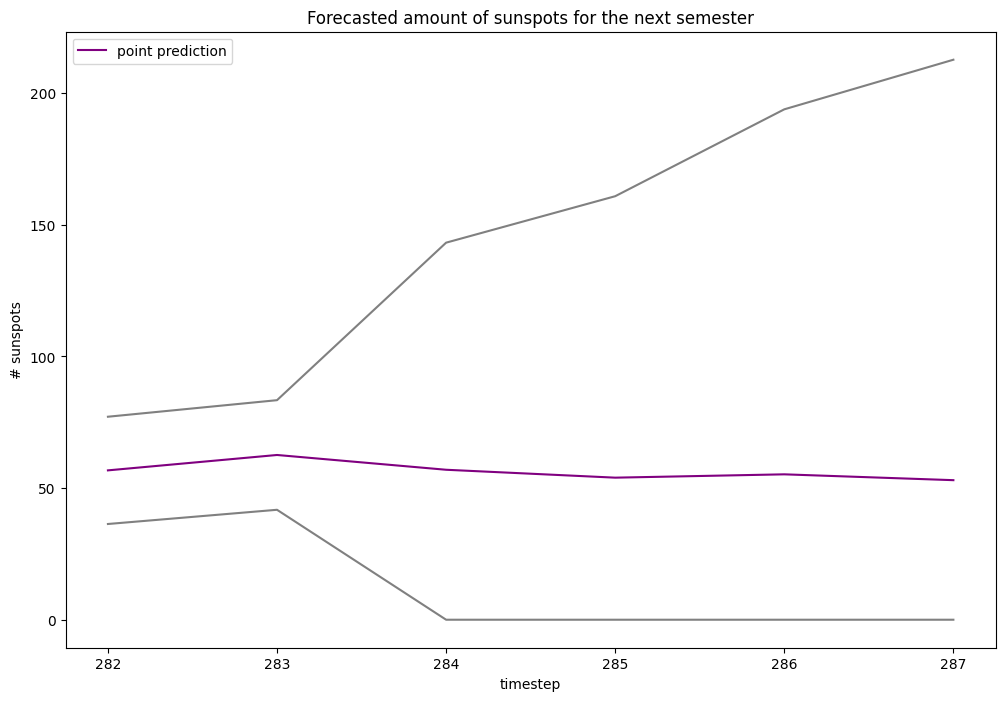

In [10]:
plt.figure(figsize=(12, 8))
plt.plot([None for _ in range(forecasts.shape[0])] + forecasts.iloc[-1]['prediction'], color='purple', label='point prediction')
plt.plot([None for _ in range(forecasts.shape[0])] + forecasts.iloc[-1]['lower'], color='grey')
plt.plot([None for _ in range(forecasts.shape[0])] + forecasts.iloc[-1]['upper'], color='grey')
plt.xlabel('timestep')
plt.ylabel('# sunspots')
plt.title("Forecasted amount of sunspots for the next semester")
plt.legend()
plt.show()

## Conclusion

In this tutorial, we have gone through how you can train a machine learning model with Lightwood to produce forecasts for a univariate time series task.

There are additional parameters to further customize your timeseries settings and/or prediction insights, so be sure to check the rest of the documentation.